In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Input, Activation, Dropout, Add, LSTM, GRU, RNN, LayerNormalization, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam,SGD
import tensorflow as tf
from keras import Model, regularizers, activations
import pickle

# disable warnings to ignore overflow error
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# parameters for CSTR
T_0_cstr = 300
V_cstr = 1
k_0_cstr = 8.46*(np.power(10,6))
C_p_cstr = 0.231
rho_L_cstr = 1000
Q_s_cstr = 0.0
F_cstr = 5
E_cstr = 5*(np.power(10,4))
delta_H_cstr = -1.15*(np.power(10,4))
R_cstr = 8.314
C_A0s_cstr = 4

t_final_cstr = 0.005
t_step_cstr = 1e-4

# parameters for Batch
V_batch = 1
k_0_batch = 8.46*(np.power(10,7))
C_p_batch = 0.231
rho_L_batch = 1000
Q_s_batch = 0
E_batch = 5*(np.power(10,4))
delta_H_batch = -1.15*(np.power(10,4))
R_batch = 8.314

t_final_batch = 0.05
t_step_batch = 1e-4

# parameters for PFR
k_0 = 8.46 * (np.power(10,6))
C_p = 0.231
rho_L = 1000
u = 2 # volumetric flow rate  (F/A) Superficial velocity
E_by_R = 5*(np.power(10,4)) / 8.314
delH_term = -1.15*(np.power(10,4))
U = 25
Tc_s = 293
At = 0.01 # Area for heating rate equation
A = 0.002  # Area
length = 1 # total length of reactor
N = 10     # number of points to discretize the reactor

t_final = 0.1 # end time for numerical simulation
t_step = 0.01 # integration time step h_c

# parameters for neural networks
num_step = 10
num_dims = 4

In [8]:
# def generate_new(x):
#     return x

# def generate_new_small(x):
#     return x

def generate_new(x):
    return x + x * np.random.uniform(-10, 10)

def generate_new_100(x):
    return x + x * np.random.uniform(-1, 1)

def generate_new_small(x):
    return x + x * np.random.uniform(-0.05, 0.05)

def generate_new_Tc_s(x):
    return x + x * np.random.uniform(-0.0668259, 1)

def CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating CSTR using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = F / V * (C_A0 - C_A) - k_0 * np.exp(-E / (R * T)) * C_A**2
        dTdt = F / V * (T_0 - T) - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A**2 + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 5 == 0:
          C_A_list.append(C_A)
          T_list.append(T)

    return C_A_list, T_list

def Batch_simulation(V, k_0, E, R, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial):
    """
        simulating Batch using forward Euler method
    """

    C_A_list = list()  # evolution of CA over time
    T_list = list()  # evolution of T over time

    C_A = C_A_initial
    T = T_initial

    for i in range(int(t_final / t_step)):
        dCAdt = -k_0 * np.exp(-E / (R * T)) * C_A
        dTdt = - delta_H / (rho_L * C_p) * k_0 * np.exp(-E / (R * T)) * C_A + Q / (rho_L * C_p * V)

        T += dTdt * t_step
        C_A += dCAdt * t_step

        if i % 50 == 0:
            C_A_list.append(C_A)
            T_list.append(T)

    return C_A_list, T_list

def PFR_simulation(u, delH_term, k_0, C_p, rho_L, E_by_R, Tc, U, At, A, t_final, t_step, init_C, init_T, length, N):

    # Method of lines approximates the spatial derivative using finite difference method which reults in a set of coupled ODE

    def method_of_lines_C(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(C) / np.diff(z) - k_0 * np.exp(-E_by_R/T[1:]) * C[1:]    # for first order
        return np.concatenate([[0], D]) #C0 is constant at entrance


    def method_of_lines_T(C, T):
        'coupled ODES at each node point'
        D = -u * np.diff(T) / np.diff(z) + (-delH_term/(rho_L*C_p)) * k_0 * np.exp(-E_by_R/T[1:])* C[1:] + (U/(rho_L*C_p*A)) * At * (Tc - T[1:]) # for first order
        return np.concatenate([[0], D]) #T0 is constant at entrance

    z = np.linspace(0, length, N) # discretized length elements

    #initializing arrays
    init_C_A_2_1 = np.zeros(N)
    init_T_2_1 = np.zeros(N)

    init_C_A_2_2 = np.zeros(N)
    init_T_2_2 = np.zeros(N)

    init_C_A_3 = np.zeros(N)
    init_T_3 = np.zeros(N)

    C_A_3 = np.zeros(N)
    T_3 = np.zeros(N)

    dCAdt1 = method_of_lines_C(init_C, init_T)
    dTdt1 = method_of_lines_T(init_C, init_T)

    for i in range(len(init_C)):
        init_C_A_2_1[i] = init_C[i] + dCAdt1[i] * t_step / 2
        init_T_2_1[i] = init_T[i] + dTdt1[i] * t_step / 2

    dCAdt2_1 = method_of_lines_C(init_C_A_2_1, init_T_2_1)
    dTdt2_1 = method_of_lines_T(init_C_A_2_1, init_T_2_1)

    for i in range(len(init_C)):
        init_C_A_2_2[i] = init_C[i] + dCAdt2_1[i] * t_step / 2
        init_T_2_2[i] = init_T[i] + dTdt2_1[i] * t_step / 2

    dCAdt2_2 = method_of_lines_C(init_C_A_2_2, init_T_2_2)
    dTdt2_2 = method_of_lines_T(init_C_A_2_2, init_T_2_2)

    for i in range(len(init_C)):
        init_C_A_3[i] = init_C[i] + dCAdt2_2[i] * t_step / 2
        init_T_3[i] = init_T[i] + dTdt2_2[i] * t_step / 2

    dCAdt3 = method_of_lines_C(init_C_A_3, init_T_3)
    dTdt3 = method_of_lines_T(init_C_A_3, init_T_3)

    dCAdt2 = np.add(dCAdt2_1,dCAdt2_2)
    dCAdt2 = np.divide(dCAdt2,2)

    dTdt2 = np.add(dTdt2_1,dTdt2_2)
    dTdt2 = np.divide(dTdt2,2)

    for i in range(len(init_C)):
        C_A_3[i] = init_C[i] + t_step / 6 * (dCAdt1[i] + 4*dCAdt2[i] + dCAdt3[i])
        T_3[i] = init_T[i] + t_step / 6 * (dTdt1[i] + 4*dTdt2[i] + dTdt3[i])

    return C_A_3 , T_3

def gen_cstr(F, V, C_A0s, k_0, E, R, T_0, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    T_0 = generate_new(T_0)
    V = generate_new(V)
    F = generate_new(F)
    C_A0s = generate_new(C_A0s)
    Q_s = generate_new(Q_s)
    rho_L = generate_new_small(rho_L)
    C_p = generate_new_small(C_p)
    k_0 = generate_new_small(k_0)
    E = generate_new_small(E)
    delta_H = generate_new_small(delta_H)

    # generating inputs and initial states for CSTR, all expressed in deviation form
    u1_list = np.linspace(-3.5, 3.5, 4, endpoint=True)
    u2_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
    T_initial = np.linspace(300, 600, 20, endpoint=True)
    CA_initial = np.linspace(0, 6, 20, endpoint=True)

    # sieve out initial states that lie outside of stability region
    T_start = list()
    CA_start = list()

    for T in T_initial:
        for CA in CA_initial:
            CA_start.append(CA)
            T_start.append(T)

    CA_start = np.array([CA_start])
    T_start = np.array([T_start])
    x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)  # every row is a pair of initial states within stability region

    # get X and y data for training and testing
    CA_output = list()
    T_output = list()
    CA_input = list()
    T_input = list()
    CA0_input = list()
    Q_input = list()

    for u1 in u1_list:
        C_A0 = u1 + C_A0s
        for u2 in u2_list:
            Q = u2 + Q_s
            for C_A_initial, T_initial in x_deviation:

                C_A_list, T_list = CSTR_simulation(F, V, C_A0, k_0, E, R, T_0, delta_H, rho_L, C_p, Q, t_final, t_step, C_A_initial, T_initial)
                if any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                    CA_output.append(C_A_list)
                    T_output.append(T_list)

                    CA0_input.append(u1)
                    Q_input.append(u2)
                    CA_input.append(C_A_initial)
                    T_input.append(T_initial)

    return CA_output, T_output

def gen_batch(V, k_0, E, R, delta_H, rho_L, C_p, Q_s, t_final, t_step, num_step):
    V_new = generate_new(V)
    Q_s_new = generate_new(Q_s)
    rho_L_new = generate_new_small(rho_L)
    C_p_new = generate_new_small(C_p)
    k_0_new = generate_new(k_0)
    E_new = generate_new_small(E)
    delta_H_new = generate_new_small(delta_H)

    # generating inputs and initial states for CSTR, all expressed in deviation form
    u_list = np.linspace(-5e5, 5e5, 4, endpoint=True)
    T_initial = np.linspace(300, 600, 40, endpoint=True)
    CA_initial = np.linspace(0, 6, 40, endpoint=True)

    # restruture the data
    T_start = list()
    CA_start = list()

    for T in T_initial:
        for CA in CA_initial:
            CA_start.append(CA)
            T_start.append(T)

    CA_start = np.array([CA_start])
    T_start = np.array([T_start])
    x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

    # get X and y data for training and testing
    CA_output = list()
    T_output = list()
    CA_input = list()
    T_input = list()
    CA0_input = list()
    Q_input = list()

    for u1 in u_list:
        Q = u1 + Q_s_new
        for C_A_initial, T_initial in x_deviation:

            C_A_list, T_list = Batch_simulation(V_new, k_0_new, E_new, R, delta_H_new, rho_L_new, C_p_new, Q, t_final, t_step, C_A_initial, T_initial)
            if any(abs(i) < 0.001 for i in T_list) == False and any(abs(i) < 0.001 for i in C_A_list) == False and any(abs(i) > 10000 for i in T_list) == False and any(abs(i) > 10000 for i in C_A_list) == False and any(abs(i) == 0 for i in T_list) == False and any(abs(i) == 0 for i in C_A_list) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                CA0_input.append(0)
                Q_input.append(u1)
                CA_input.append(C_A_initial)
                T_input.append(T_initial)

                CA_output.append(C_A_list)
                T_output.append(T_list)

    return CA_output, T_output

In [9]:
def gen_pfr(u, delH_term, k_0, C_p, rho_L, E_by_R, U, At, A, Tc_s, length, N, t_final, t_step):
    u_new = generate_new_100(u)
    U_new = generate_new_100(U)
    A_new = generate_new(A)
    At_new = generate_new(At)
    Tc_s_new = generate_new_Tc_s(Tc_s)
    rho_L_new = generate_new_small(rho_L)
    C_p_new = generate_new_small(C_p)
    k_0_new = generate_new_small(k_0)
    E_by_R_new = generate_new_small(E_by_R)
    delH_term_new = generate_new_small(delH_term)

    # generating inputs and initial states for CSTR, all expressed in deviation form
    u_list = np.linspace(100, 300, 4, endpoint=True)
    T_initial = np.linspace(300, 500, 40, endpoint=True)
    CA_initial = np.linspace(0.5, 3, 40, endpoint=True)

    # restruture the data
    T_start = list()
    CA_start = list()

    for T in T_initial:
        for CA in CA_initial:
            CA_start.append(CA)
            T_start.append(T)

    CA_start = np.array([CA_start])
    T_start = np.array([T_start])
    x_deviation = np.concatenate((CA_start.T, T_start.T), axis=1)

    # get X and y data for physics-informed model
    CA_output = list()
    T_output = list()
    CA_input = list()
    T_input = list()
    Tc_input = list()

    for u2 in u_list:
        Tc = u2 + Tc_s_new

        for C_A_initial, T_initial in x_deviation:

            z = np.linspace(0, length, N) # discretized length elements

            init_C = np.zeros(N)    # Concentration in reactor at t = 0
            init_C[0] = C_A_initial          # concentration at entrance
            init_T = np.zeros(N)    # T in reactor at t = 0
            for i in range(len(init_T)):
                if i == 0:
                    init_T[i] = T_initial
                else:
                    init_T[i] = Tc_s_new

            C_A_list = list()
            T_list = list()

            for i in range(int(t_final / t_step)):

                CA_next, T_next = PFR_simulation(u_new, delH_term_new, k_0_new, C_p_new, rho_L_new, E_by_R_new, Tc, U_new, At_new, A_new, t_final, t_step, init_C, init_T, length, N)
                if i % 1 == 0:
                    C_A_list.append(CA_next)
                    T_list.append(T_next)
                init_C = CA_next
                init_T = T_next
            if any(abs(i) < 0.001 for i in np.array(T_list)[:,1]) == False and any(abs(i) < 0.001 for i in np.array(C_A_list)[:,1]) == False and any(abs(i) > 10000 for i in np.array(T_list)[:,1]) == False and any(abs(i) > 10000 for i in np.array(C_A_list)[:,1]) == False and any(abs(i) == 0 for i in np.array(T_list)[:,1]) == False and any(abs(i) == 0 for i in np.array(C_A_list)[:,1]) == False and np.isnan(C_A_list).any() == False and np.isnan(T_list).any() == False and np.isinf(C_A_list).any() == False and np.isinf(T_list).any() == False:
                Tc_input.append(u2)
                CA_input.append(C_A_initial)
                T_input.append(T_initial)

                CA_output.append(C_A_list)
                T_output.append(T_list)
    return CA_output, T_output

In [10]:
for i in range(20):
    CA_positive, T_positive = gen_pfr(u, delH_term, k_0, C_p, rho_L, E_by_R, U, At, A, Tc_s, length, N, t_final, t_step)
    # CA_positive, T_positive = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step)
    # CA_positive, T_positive = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step)
    print(len(CA_positive))
    if len(CA_positive) > 10:
      CA_positive = np.array(CA_positive)[:,:,1]
      T_positive = np.array(T_positive)[:,:,1]
      print(CA_positive[15])
      print(T_positive[15])
    print('\n')

6400
[0.23962335 0.43172379 0.59489614 0.73448576 0.85330282 0.95378513
 1.03830799 1.10912615 1.1682956  1.21763472]
[429.12238872 407.59497207 389.54322288 374.354669   361.60166282
 350.9241707  342.00602141 334.57081207 328.38001432 323.23011927]


6400
[0.37882878 0.65760045 0.87211281 1.03261308 1.15056203 1.23647618
 1.29878532 1.34387397 1.37646131 1.39999657]
[438.49124162 400.06909421 371.49132908 350.45697831 335.08346152
 323.8870102  315.7469262  309.83424201 305.54160551 302.42603908]


6400
[0.18710402 0.34370094 0.48116067 0.60319815 0.71147056 0.80715502
 0.89136587 0.96522166 1.02982156 1.08621174]
[446.83589782 427.85381311 411.30302803 396.80200338 384.09887028
 372.98829548 363.28743416 354.82998135 347.46514279 341.05740554]


6400
[0.22761323 0.41630768 0.57614483 0.71216249 0.82785012 0.92607513
 1.00932798 1.07978932 1.13935828 1.18967646]
[412.26004564 395.03266674 380.50815656 368.22940244 357.85188185
 349.08985688 341.69926357 335.47064837 330.22472378 325.

In [ ]:
CA_positive_batch, T_positive_batch = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step)
print(len(CA_positive_batch))

CA_positive_cstr, T_positive_cstr = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step)
print(len(CA_positive_cstr))

2040
6400


In [ ]:
CA_negative_batch, T_negative_batch = gen_batch(V_batch, k_0_batch, E_batch, R_batch, delta_H_batch, rho_L_batch, C_p_batch, Q_s_batch, t_final_batch, t_step_batch, num_step)
print(len(CA_negative_batch))

CA_negative_cstr, T_negative_cstr = gen_cstr(F_cstr, V_cstr, C_A0s_cstr, k_0_cstr, E_cstr, R_cstr, T_0_cstr, delta_H_cstr, rho_L_cstr, C_p_cstr, Q_s_cstr, t_final_cstr, t_step_cstr, num_step)
print(len(CA_negative_cstr))

5623
5935


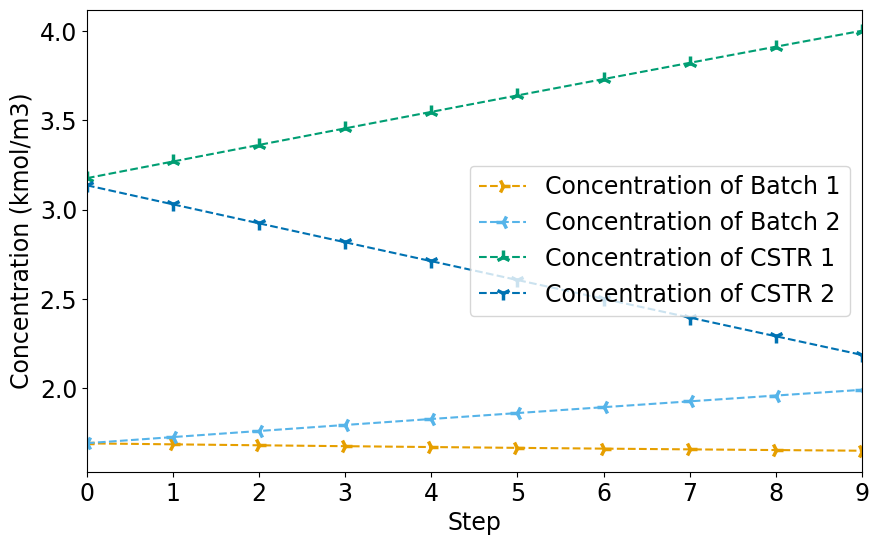

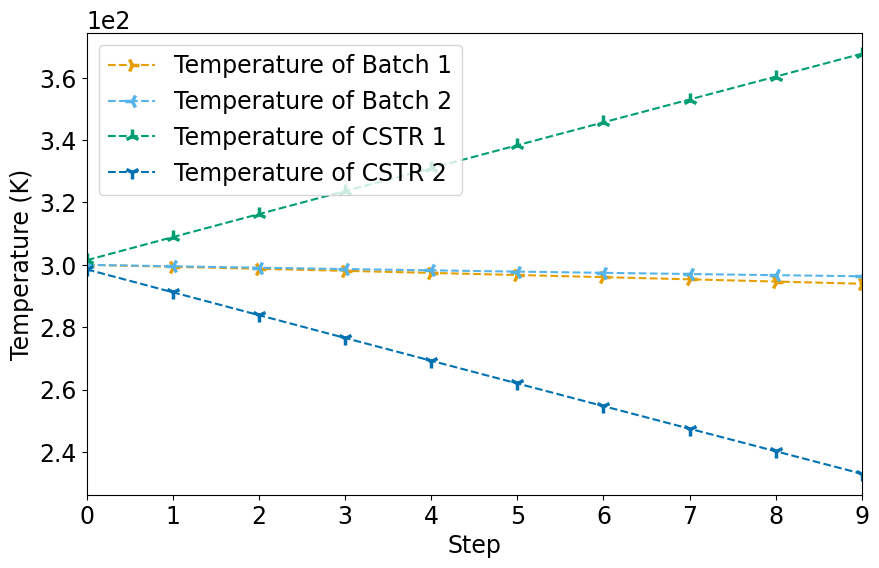

In [ ]:
# load packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

num = 10

size = 10
x = np.arange(0,size,1)

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, CA_positive_batch[num], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Concentration of Batch 1')
plt.plot(x, CA_negative_batch[num], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Concentration of Batch 2')
plt.plot(x, CA_positive_cstr[num], '--', color='#009E73', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Concentration of CSTR 1')
plt.plot(x, CA_negative_cstr[num], '--', color='#0072B2', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Concentration of CSTR 2')
plt.legend()
plt.xlabel("Step")
plt.ylabel("Concentration (kmol/m3)")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.savefig('CA_extreme.pdf')
plt.show()

# color code: "#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"
plt.figure(figsize=(10,6))
plt.rc('font', size=17)
plt.plot(x, T_positive_batch[num], '--', color='#E69F00', marker='4', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Temperature of Batch 1')
plt.plot(x, T_negative_batch[num], '--', color='#56B4E9', marker='3', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Temperature of Batch 2')
plt.plot(x, T_positive_cstr[num], '--', color='#009E73', marker='2', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Temperature of CSTR 1')
plt.plot(x, T_negative_cstr[num], '--', color='#0072B2', marker='1', linewidth=1.5, markersize=10, markeredgewidth=2.5, label='Temperature of CSTR 2')
plt.legend()
plt.xlabel("Step")
plt.ylabel("Temperature (K)")
plt.margins(x=0)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
# plt.savefig('CA_extreme.pdf')
plt.show()

In [ ]:
import random
count = []
for i in range(1000):
  count.append(random.randint(0, 1))

count1 = 0
count0 = 0
for item in count:
  if item == 1:
    count1 = count1 + 1
  elif item == 0:
    count0 = count0 + 1

print(count1)
print(count0)

531
469
